Code adapted from https://github.com/patrickcgray/open-geo-tutorial

In [106]:
from IPython.display import Audio, display
def alert():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

# Preparing Dataset

#### Cutting images for faster process

In [107]:
# 0 to  10980 for this img_data
cutx = 7000
cuty = 8500

In [108]:
import rasterio
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon , mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
import pyproj
from pyproj import CRS
import fiona

In [109]:
import os # we need os to do some basic file operations
import re
regexp = re.compile(r'_B0[2348]')
sentinal_20m = "./data/IMG_DATA_1"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_20m, f) for f in os.listdir(sentinal_20m) if regexp.search(f) ]
sentinal_band_paths.sort()
sentinal_band_paths

['./data/IMG_DATA_1\\T29SMD_20191025T113321_B02.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B03.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B04.jp2',
 './data/IMG_DATA_1\\T29SMD_20191025T113321_B08.jp2']

In [110]:
for i in sentinal_band_paths : 
        src = rasterio.open(i,driver='JP2OpenJPEG')
        meta = src.meta
        print( i + " ::: ")
        print(meta)


./data/IMG_DATA_1\T29SMD_20191025T113321_B02.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B03.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B04.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}
./data/IMG_DATA_1\T29SMD_20191025T113321_B08.jp2 ::: 
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.

In [111]:
# create a products directory within the data dir which won't be uploaded to Github
img_dir = './data/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands_img_data_1.tif'

### Only run this the first time - its slow

In [112]:
# Just run this the first time 
meta = meta
# Update metadata to reflect the number of layers
meta.update(
    count = len(sentinal_band_paths)
)
# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [113]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape) # dimensions
print(full_dataset.count) # bands

(10980, 10980)
4


In [114]:
dataset=full_dataset
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
if (not proj) :
    proj = CRS.from_epsg(4326)
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ./data/sentinel_bands_img_data_1.tif

Number of bands in image: 4

Image size is: 10980 rows x 10980 columns

Raster description: (None, None, None, None)

Raster driver: JP2OpenJPEG

Image projection:
EPSG:32629 

Image geo-transform:
| 10.00, 0.00, 399960.00|
| 0.00,-10.00, 4400040.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32629), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 4400040.0)}




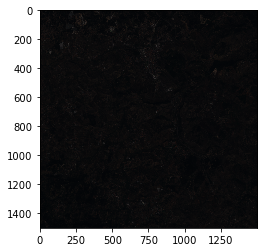

In [115]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
cutted = dataset.read([3,2,1])[:,cutx : cuty,cutx : cuty]
full = dataset.read([3,2,1])
rgb_norm = adjust_band(cutted) # normalize bands to range between 1.0 to 0.0

show(rgb_norm)

(3, 1500, 1500)


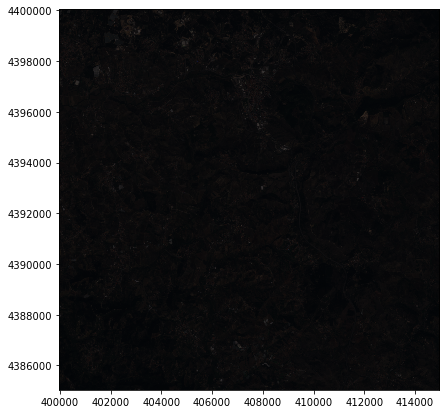

In [116]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = adjust_band(cutted)
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:,  : , : ], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords

# Indices

In [117]:

with rasterio.open(img_fp) as src:
    green_band = src.read(2)[ cutx : cuty ,  cutx : cuty ] # band 3
    red_band = src.read(3)[ cutx : cuty ,  cutx : cuty ]   # band 4
    nir_band = src.read(4)[ cutx : cuty ,  cutx : cuty ]   # band 8
    img = src.read()[:,  cutx : cuty ,  cutx : cuty ]
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

In [118]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

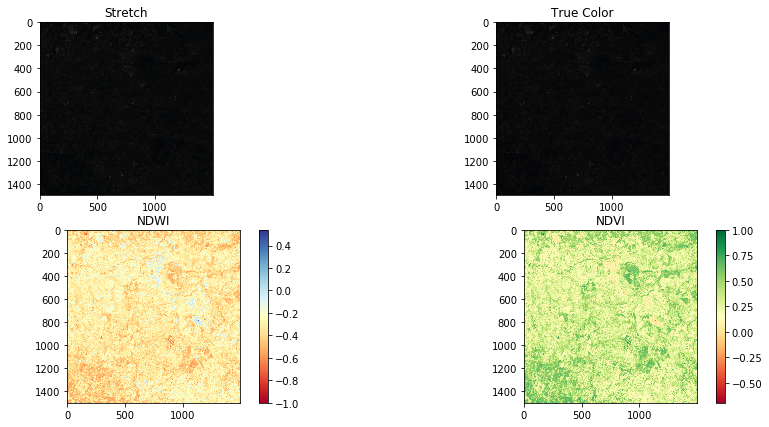

In [119]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

reshaped_img =reshape_as_image( img )
img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0,0].set_title("Stretch")
axs[0,0].imshow(img_stretched)

axs[0,1].set_title("True Color")
axs[0,1].imshow(reshape_as_image(rgb_norm))

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

In [120]:
src.close()

# Intercepting label data with cutting image

In [121]:
# Open the dataset from the file
shapefile = gp.read_file('./data/shapefiles/shapefile_compressed/shp_2012_IMG_DATA_1.shp')
shapefile = shapefile.filter(['Legenda','geometry','CLC2012'])
shapefile.crs = {'init': 'epsg:4326'}

In [122]:
shapefile

,Legenda,geometry,CLC2012
0,Tecido urbano contínuo,"POLYGON ((-9.27768 38.76588, -9.27746 38.76555...",111
1,Tecido urbano contínuo,"POLYGON ((-9.25850 38.76457, -9.25850 38.76158...",111
2,Tecido urbano contínuo,"POLYGON ((-9.21069 38.76698, -9.21064 38.76633...",111
3,Tecido urbano contínuo,"POLYGON ((-9.22487 38.76998, -9.22474 38.76907...",111
4,Tecido urbano contínuo,"POLYGON ((-9.15237 38.77167, -9.15397 38.77135...",111
...,...,...,...
2606,Planos de água,"POLYGON ((-9.30538 39.32667, -9.30438 39.32591...",512
2607,Planos de água,"POLYGON ((-9.12876 39.36121, -9.12819 39.36034...",512
2608,Lagoas costeiras,"POLYGON ((-9.22812 39.43133, -9.22765 39.43071...",521
2609,Desembocaduras fluviais,"POLYGON ((-8.99046 38.92315, -8.99021 38.92267...",522


In [123]:
shapefile = shapefile.to_crs({'init': 'epsg:32629'})

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [124]:
shapefile.bounds

,minx,miny,maxx,maxy
0,474782.521060,4.288877e+06,476430.681811,4.290843e+06
1,476591.348965,4.289766e+06,477555.487955,4.290956e+06
2,480560.441620,4.290757e+06,481700.696947,4.291425e+06
3,477478.133322,4.287956e+06,482136.028108,4.291520e+06
4,486477.998487,4.291415e+06,487108.983959,4.292233e+06
...,...,...,...,...
2606,472616.358933,4.352466e+06,474147.798607,4.353889e+06
2607,488111.339739,4.355853e+06,490649.235019,4.357006e+06
2608,479637.064347,4.359617e+06,484220.218501,4.364724e+06
2609,471843.279019,4.272805e+06,507900.408025,4.309807e+06


Img_data_1 cutted

In [125]:
from pyproj import transform
from pyproj import Proj
# this will get our four corner points
xmin = cutx 
ymin = cutx
xmax = cuty
ymax = cuty
raster_gps_points = full_dataset.transform * (xmin, ymin),full_dataset.transform * (xmax, ymin),full_dataset.transform * (xmax, ymax), full_dataset.transform * (xmin, ymax),
# Project all longitudes, latitudes using the pyproj package
p1 = Proj(dataset.crs) # our current crs

print('raster bounds in current crs :\n', raster_gps_points)

raster bounds in current crs :
 ((469960.0, 4330040.0), (484960.0, 4330040.0), (484960.0, 4315040.0), (469960.0, 4315040.0))


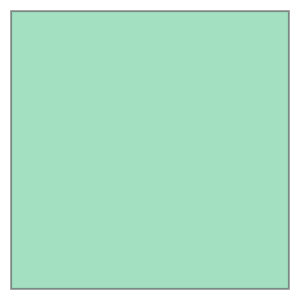

In [126]:
polygon = Polygon( list(raster_gps_points))
polygon

In [127]:
imageBounds = gp.GeoDataFrame(crs=CRS.from_epsg(32629))

In [128]:
imageBounds.geometry = [polygon]

In [129]:
imageBounds = imageBounds.to_crs(fiona.crs.from_epsg(4326))
imageBounds.bounds

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,minx,miny,maxx,maxy
0,-9.347498,38.983836,-9.17365,39.11939


In [130]:
shapefile = shapefile.to_crs(fiona.crs.from_epsg(4326))
shapefile.bounds

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,minx,miny,maxx,maxy
0,-9.290231,38.748262,-9.271269,38.765971
1,-9.269420,38.756289,-9.258351,38.767022
2,-9.223762,38.765308,-9.210637,38.771348
3,-9.259214,38.740093,-9.205557,38.772182
4,-9.155668,38.771354,-9.148402,38.778720
...,...,...,...,...
2606,-9.317734,39.321207,-9.299920,39.333992
2607,-9.137997,39.352063,-9.108531,39.362436
2608,-9.236594,39.385820,-9.183275,39.431828
2609,-9.323687,38.603732,-8.908901,38.937196


In [131]:
intersected = gp.sjoin( shapefile, imageBounds, how='inner', op='intersects', lsuffix='left', rsuffix='right')
intersected = intersected.reset_index()
intersected

,index,Legenda,geometry,CLC2012,index_right
0,32,Tecido urbano contínuo,"POLYGON ((-9.26163 39.09542, -9.26116 39.09542...",111,0
1,172,Tecido urbano descontínuo,"POLYGON ((-9.21337 38.98823, -9.21181 38.98803...",112,0
2,173,Tecido urbano descontínuo,"POLYGON ((-9.19590 38.98818, -9.19547 38.98819...",112,0
3,174,Tecido urbano descontínuo,"POLYGON ((-9.23920 38.98954, -9.23956 38.98947...",112,0
4,179,Tecido urbano descontínuo,"POLYGON ((-9.33071 38.99944, -9.32990 38.99906...",112,0
...,...,...,...,...,...
184,2430,"Florestas abertas, cortes e novas plantações","POLYGON ((-9.32795 39.11017, -9.32737 39.11016...",324,0
185,2432,"Florestas abertas, cortes e novas plantações","POLYGON ((-9.24651 39.12163, -9.24716 39.12077...",324,0
186,2434,"Florestas abertas, cortes e novas plantações","POLYGON ((-9.21848 39.12293, -9.21795 39.12275...",324,0
187,2435,"Florestas abertas, cortes e novas plantações","POLYGON ((-9.31016 39.12303, -9.30996 39.12280...",324,0


In [132]:
intersected.crs

{'init': 'epsg:4326', 'no_defs': True}

In [133]:
intersected.bounds

,minx,miny,maxx,maxy
0,-9.267174,39.085102,-9.250856,39.095425
1,-9.220052,38.981527,-9.207328,38.989144
2,-9.203659,38.985857,-9.188445,38.990987
3,-9.244250,38.988825,-9.236600,38.994942
4,-9.336180,38.989667,-9.327850,38.999997
...,...,...,...,...
184,-9.331864,39.104885,-9.319343,39.117345
185,-9.254435,39.113952,-9.240851,39.122348
186,-9.226259,39.117421,-9.210648,39.124955
187,-9.317537,39.116659,-9.306785,39.124090


In [134]:
import re
def class_from_CLCcode(clc) :
    mega_classes = {
        '^1.*' : 'Territórios artificializados',
        '^2.*' : 'Agricultura',
        '^31.*' : 'Floresta',
        '^3.4' : 'Floresta',
        '^32[123]' : 'Vegetação natural',
        '^33[123]' : 'Espaços descobertos ou com vegetação esparsa',
        '^41.*' : 'Zonas húmidas',
        '^42[13]' : 'Zonas húmidas',
        '^5.*' : 'Corpos de água',
        '^422' : 'Corpos de água'
    }
    for mega_class_key in mega_classes :
        searched =  re.search(mega_class_key, str(clc))
        if searched is not None:
            return mega_classes[mega_class_key]
    return 'Not Defined'

x = intersected['CLC2012'][0] 
print (x)
class_from_CLCcode (x) 

111


'Territórios artificializados'

In [135]:
for i in intersected.index:
    clc = intersected.at[i, 'CLC2012']
    new_class = class_from_CLCcode(clc)
    intersected.at[i, 'Mega_Legenda'] = new_class
intersected.head()

,index,Legenda,geometry,CLC2012,index_right,Mega_Legenda
0,32,Tecido urbano contínuo,"POLYGON ((-9.26163 39.09542, -9.26116 39.09542...",111,0,Territórios artificializados
1,172,Tecido urbano descontínuo,"POLYGON ((-9.21337 38.98823, -9.21181 38.98803...",112,0,Territórios artificializados
2,173,Tecido urbano descontínuo,"POLYGON ((-9.19590 38.98818, -9.19547 38.98819...",112,0,Territórios artificializados
3,174,Tecido urbano descontínuo,"POLYGON ((-9.23920 38.98954, -9.23956 38.98947...",112,0,Territórios artificializados
4,179,Tecido urbano descontínuo,"POLYGON ((-9.33071 38.99944, -9.32990 38.99906...",112,0,Territórios artificializados


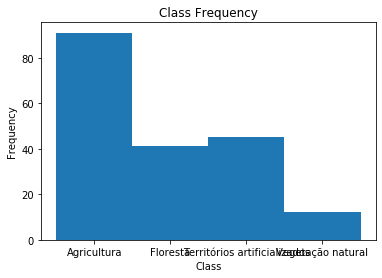

Number of different classes :4
['Agricultura' 'Floresta' 'Territórios artificializados'
 'Vegetação natural']


In [136]:
import matplotlib.pyplot as plt
unique, counts = np.unique(intersected['Mega_Legenda'], return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

print('Number of different classes :'  + str(len(unique)))
print(unique)

# Setting up label data with bands

In [137]:
shapefile = intersected
shapefile.head()

,index,Legenda,geometry,CLC2012,index_right,Mega_Legenda
0,32,Tecido urbano contínuo,"POLYGON ((-9.26163 39.09542, -9.26116 39.09542...",111,0,Territórios artificializados
1,172,Tecido urbano descontínuo,"POLYGON ((-9.21337 38.98823, -9.21181 38.98803...",112,0,Territórios artificializados
2,173,Tecido urbano descontínuo,"POLYGON ((-9.19590 38.98818, -9.19547 38.98819...",112,0,Territórios artificializados
3,174,Tecido urbano descontínuo,"POLYGON ((-9.23920 38.98954, -9.23956 38.98947...",112,0,Territórios artificializados
4,179,Tecido urbano descontínuo,"POLYGON ((-9.33071 38.99944, -9.32990 38.99906...",112,0,Territórios artificializados


In [138]:
shapefile = shapefile.filter(['Legenda','Mega_Legenda', 'geometry','CLC2012'])
shapefile

,Legenda,Mega_Legenda,geometry,CLC2012
0,Tecido urbano contínuo,Territórios artificializados,"POLYGON ((-9.26163 39.09542, -9.26116 39.09542...",111
1,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((-9.21337 38.98823, -9.21181 38.98803...",112
2,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((-9.19590 38.98818, -9.19547 38.98819...",112
3,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((-9.23920 38.98954, -9.23956 38.98947...",112
4,Tecido urbano descontínuo,Territórios artificializados,"POLYGON ((-9.33071 38.99944, -9.32990 38.99906...",112
...,...,...,...,...
184,"Florestas abertas, cortes e novas plantações",Floresta,"POLYGON ((-9.32795 39.11017, -9.32737 39.11016...",324
185,"Florestas abertas, cortes e novas plantações",Floresta,"POLYGON ((-9.24651 39.12163, -9.24716 39.12077...",324
186,"Florestas abertas, cortes e novas plantações",Floresta,"POLYGON ((-9.21848 39.12293, -9.21795 39.12275...",324
187,"Florestas abertas, cortes e novas plantações",Floresta,"POLYGON ((-9.31016 39.12303, -9.30996 39.12280...",324


Choose target column = Legenda or Mega_Legenda

In [139]:
Class = 'Mega_Legenda' 

In [140]:
unique= np.unique(shapefile[Class])
print('List of Land Cover Classes:')
unique

List of Land Cover Classes:


array(['Agricultura', 'Floresta', 'Territórios artificializados',
       'Vegetação natural'], dtype=object)

In [141]:
full_dataset.crs	

CRS.from_epsg(32629)

In [142]:
shapefile.crs

{'init': 'epsg:4326', 'no_defs': True}

In [143]:
#shapefile = shapefile.to_crs(proj)
#shapefile = shapefile.to_crs({'init': 'epsg:4326'})
if shapefile.crs != {'init': 'epsg:32629'} :
    shapefile = shapefile.to_crs({'init': 'epsg:32629'})
shapefile.crs

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:32629'}

In [144]:
#shapefile.geometry = shapefile.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

In [145]:
shapefile.bounds

,minx,miny,maxx,maxy
0,476894.860946,4.326253e+06,478304.977772,4.327398e+06
1,480940.411983,4.314749e+06,482044.181711,4.315594e+06
2,482361.886182,4.315224e+06,483679.398555,4.315796e+06
3,478847.508599,4.315564e+06,479509.755004,4.316243e+06
4,470887.902215,4.315682e+06,471610.141417,4.316828e+06
...,...,...,...,...
184,471309.536011,4.328467e+06,472390.997745,4.329850e+06
185,478005.043468,4.329450e+06,479178.571337,4.330383e+06
186,480441.270324,4.329830e+06,481790.826770,4.330666e+06
187,472551.551668,4.329769e+06,473479.685229,4.330594e+06


In [146]:
print('raster bounds in current crs :\n', raster_gps_points)

raster bounds in current crs :
 ((469960.0, 4330040.0), (484960.0, 4330040.0), (484960.0, 4315040.0), (469960.0, 4315040.0))


In [147]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((477375.754673473 4327398.128762786, 477415.7575452388 4327397.510956158, 477498.2819108996 4327398.298445963, 477539.597260113 4327393.534898428, 477656.8333737177 4327325.443717029, 477793.425289171 4327225.688609947, 477927.1517106933 4327147.181224048, 477999.6073584379 4327078.725119205, 478101.5741781429 4326983.957433442, 478171.3627542231 4326933.143335021, 478195.307215188 4326915.704105185, 478235.0040161815 4326891.2618957, 478276.1015209368 4326830.872134106, 478304.977771933 4326627.623285347, 478296.4564142741 4326579.654002256, 478286.7286721122 4326569.738847747, 478278.6714023142 4326561.526348798, 478257.7222316383 4326561.326473829, 478215.7668854949 4326566.912201621, 478179.5685912016 4326596.496741313, 478166.3382293407 4326609.477125668, 478100.972004367 4326575.521042018, 478062.5566312975 4326555.565119636, 478047.633315973 4326532.710685907, 478023.8657581611 4326498.054614481, 477993.2113884718 4326463.33673

In [148]:
out_image, out_transform = rasterio.mask.mask(full_dataset, feature,crop=True)
out_image.shape

(4, 115, 142)

In [149]:
out_transform

Affine(10.0, 0.0, 476890.0,
       0.0, -10.0, 4327400.0)

In [150]:
X = np.array([], dtype=np.int8).reshape(0,4) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
src = full_dataset
band_count = src.count
i=0
for index, geom in enumerate(geoms):
    feature = [mapping(geom)]

    # the mask function returns an array of the raster pixels within this feature
    out_image, out_transform = rasterio.mask.mask(src, feature,crop=True)
    # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
    out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
    # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
    out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
    # reshape the array to [pixel count, bands]
    out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
    # append the labels to the y array
    y = np.append(y,[shapefile[Class][index]] * out_image_reshaped.shape[0]) 
    # stack the pizels onto the pixel array
    X = np.vstack((X,out_image_reshaped))

In [151]:
# What are our classification labels?
labels = np.unique(shapefile[Class])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


The training data include 4 classes: ['Agricultura' 'Floresta' 'Territórios artificializados'
 'Vegetação natural']

Our X matrix is sized: (4840833, 4)
Our y array is sized: (4840833,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

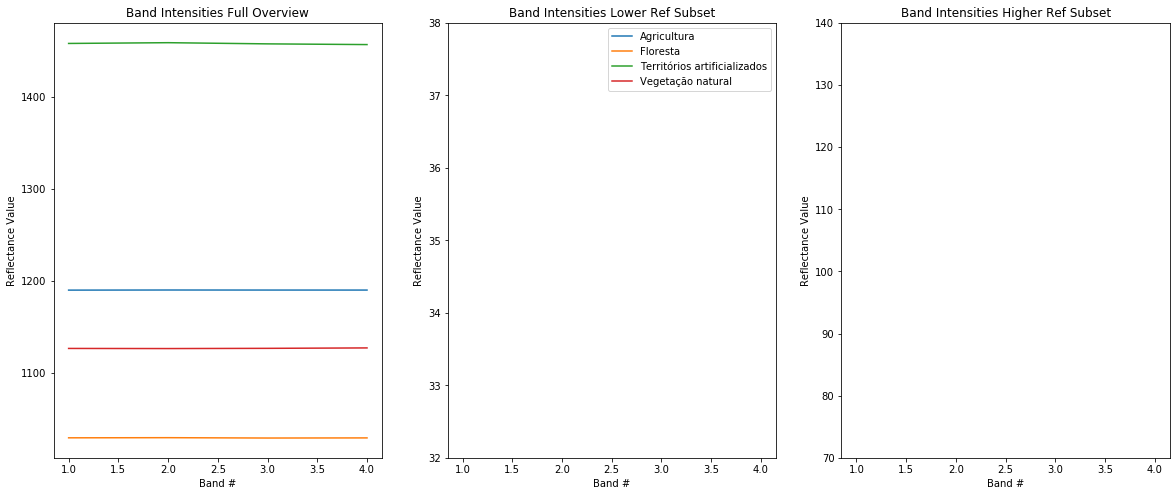

In [152]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-4
band_count = np.arange(1,5)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In [153]:
def str_class_to_int(class_array):
    class_array[class_array == 'Territórios artificializados'] = 0
    class_array[class_array == 'Agricultura'] = 1
    class_array[class_array == 'Floresta'] = 2
    class_array[class_array == 'Vegetação natural'] = 3
    class_array[class_array == 'Espaços descobertos ou com vegetação esparsa'] = 4
    class_array[class_array == 'Zonas húmidas'] = 5
    class_array[class_array == 'Corpos de água'] = 6
    return(class_array.astype(int))

# Supervised Classification Algorithm

In [154]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [155]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, cutx:cuty, cutx:cuty]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(4, 1500, 1500)
(1500, 1500, 4)


In [156]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 4))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [157]:
class_prediction = str_class_to_int(class_prediction)

# Visualizing results 

In [158]:
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (60, 60, 60, 255)),     # Grey - Territórios artificializados
    (1, (20,230,20, 255)),      # Light Green - Agricultura
    (2, (5, 80, 5, 255)),       # Dark Green - Floresta
    (3, (170, 200, 20, 255)),   # Yellow - Vegetação natural
    (4, (50, 20, 0, 255)),      # Brown - Espaços descobertos ou com vegetação esparsa
    (5, (0, 250, 250, 255)),    # Light Blue - Zonas húmidas
    (6, (0, 0, 200, 255)),      # Dark Blue - Corpos de água
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


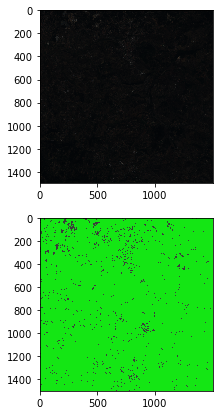

In [159]:

fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


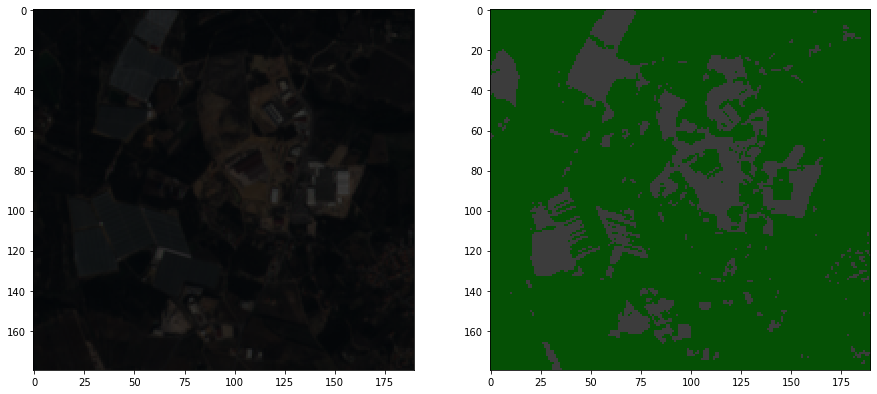

In [160]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0].imshow(img_stretched[0:180, 160:350])

axs[1].imshow(class_prediction[0:180, 160:350], cmap=cmap, interpolation='none')

fig.show()

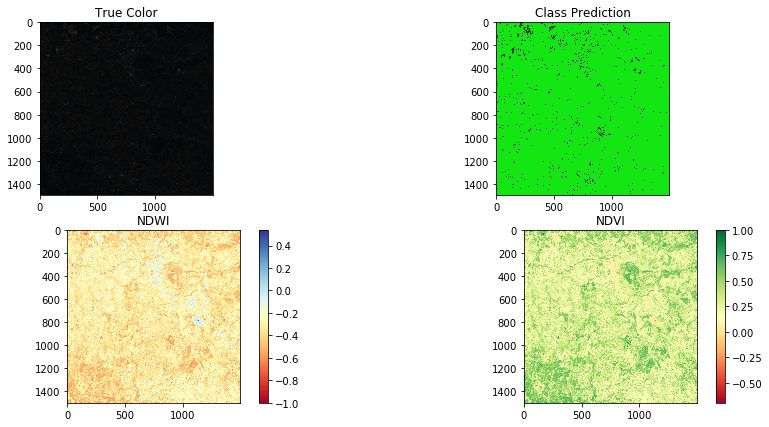

In [161]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

reshaped_img =reshape_as_image( img )
img_stretched = color_stretch(reshaped_img, [2, 1, 0])
axs[0,0].set_title("True Color")
axs[0,0].imshow(img_stretched)

axs[0,1].set_title("Class Prediction")
axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlBu")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

In [162]:
alert() # audio alert